## Introduction

The purpose of this notebook is to show the backbone of creating a machine learning model. It's nothing advanced, just basic steps to go through during 10 minutes.

## 1. Import packages

First, we have to import some Python packages. I will use the random forest model, similar to the [Intro to Machine Learning Lesson 6: Random Forests](https://www.youtube.com/watch?v=EE2QmzFI5XM) in Kaggle's video tutorial.

In [1]:
import pandas as pd                                    # data processing
from sklearn.ensemble import RandomForestClassifier    # random forest
from sklearn.model_selection import train_test_split   # split train and test dataset
from sklearn.metrics import mean_absolute_error        # mean absolute error
import matplotlib.pyplot as plt                        # plots
import seaborn as sns                                  # plots

## 2. Load and explore data

Now we can load and explore the data.

In [4]:
# load data
train = pd.read_csv("Data/train.csv") # train data
test = pd.read_csv("Data/test.csv")   # test data

# explore the structure
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Here we see the basic structure of the dataset.

We can also quickly explore the number of missing values in both datasets. I do that by running `train.isna().sum()` and `test.isna().sum()`, but for short overview I like this command:

In [7]:
# explore missing values
pd.concat([train.isna().sum(), test.isna().sum()], axis = 1).T

PassengerId  Survived  Pclass  Name  Sex    Age  SibSp  Parch  Ticket  \
0          0.0       0.0     0.0   0.0  0.0  177.0    0.0    0.0     0.0   
1          0.0       NaN     0.0   0.0  0.0   86.0    0.0    0.0     0.0   

   Fare  Cabin  Embarked  
0   0.0  687.0       2.0  
1   1.0  327.0       0.0

I would like to visualize the cerrelation between pairs of features to see, which feature has the impact for survival. Lower absolute value ~ lower impact (and more green/orange ~ higher impact). See the _Survived_ row below: _PClass_ seems to have the most negative impact od survival (-0.34), _Fare_ seems to have the most positive impact on survival (+0.26). Note that this is only a simplistic explanation&hellip;

<AxesSubplot:>

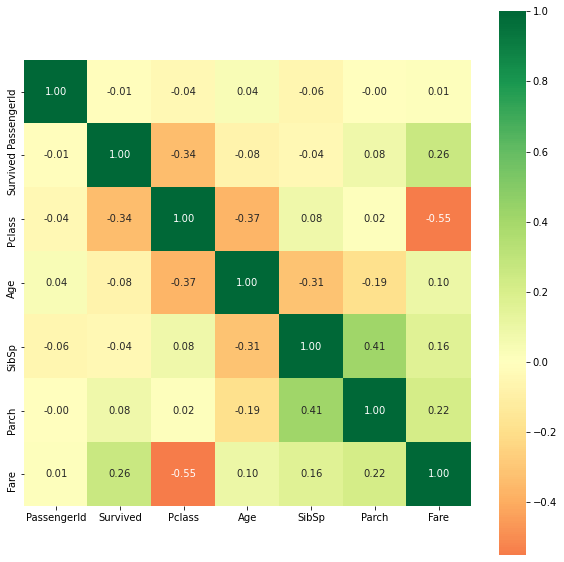

In [8]:
# some correlation heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), square = True, annot = True, fmt = ".2f", center = 0, cmap = "RdYlGn")

## 3. Prepare datasets

We'll do our model on only _a part of training dataset_ first. Then we'll validate various configurations to pick the best one.

Only after that we'll fit a model on _all_ training data and make a prediction for the test dataset.

In [22]:
# choose the target variable (survived or not?)
target = train["Survived"]

# choose some random features
# - in fact, drop only PassengerId and Age columns as these seem to have the lowest correlation
#   with Survived feature (see the heatmap above)
# - it would be better to explore them thouroughly first, but it's out of scope
#   for this tutorial
features = ["Pclass", "Sex", "Age", "Parch", "Fare"]

# process the datasets:
# pd.get_dummies()  converts categorical variables into dummy variables
# .fillna()         replaces NAs with median of particular column
train_data = pd.get_dummies(train[features].fillna(train.median()))
test_data = pd.get_dummies(test[features].fillna(train.median()))

# split train and validation datasets from the training data;
# this is useful since I want to validate the model first
train_X, val_X, train_y, val_y = train_test_split(train_data, target, random_state = 1)

Now we have

* `train_X` and `train_y` for fitting first model
* `val_X` and `val_y` for validating a model
* `train_data` and `target` for fitting final model
* `test_data` for final predictions

## 4. Model

First, evaluate some possible configurations in models.

In [23]:
# helper function that estimates the minimal absolute error (MAE) of a model
def evaluate_model(n_estimators, max_depth):
    """
    Evaluate the random forest model on validation data.
    
    Parameters:
        n_estimators (int): The number of trees in the forest.
        max_depth (int): The maximum depth of the tree.
  
    Returns:
        float: mean absolute error of the random forest model
    """
    # use global data portions
    global train_X, train_y, val_X, val_y
    # create model
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   max_depth = max_depth,
                                   random_state = 1)
    # fit model
    model.fit(train_X, train_y)
    # predict
    val_predictions = model.predict(val_X)
    # return mean absolute error of that model
    return mean_absolute_error(val_y, val_predictions)

Now we choose a final model with the best configuration (i.e. the smallest mean absolute error).


In [28]:
# find the best configuration for n_estimators and max_depth in random forest
# (looking for the lowest minimal absolute error MAE)
min_n_est = min_max_dp = min_mae = 0

print("n_est", "max_dp", "mean absolute error", sep = "\t")
for n_estimators in [20, 50, 100]:
    for max_depth in [5, 10, 20]:
        
        eval_mae = round(evaluate_model(n_estimators, max_depth), 3)
        if min_mae == 0 or eval_mae < min_mae:   # if we found a lower MAE, store that for final model
            min_n_est = n_estimators; min_max_dp = max_depth; min_mae = eval_mae
        print(n_estimators, max_depth, eval_mae, sep = "\t")
        
print("Found minimal MAE", min_mae, "with n_est", min_n_est, "and max_dp", min_max_dp)

n_est	max_dp	mean absolute error
20	5	0.197
20	10	0.179
20	20	0.22
50	5	0.197
50	10	0.206
50	20	0.229
100	5	0.206
100	10	0.211
100	20	0.215
Found minimal MAE 0.179 with n_est 20 and max_dp 10


Here we can fit a model on complete train dataset (i.e. `train_data` and `target`).

In [25]:
# 1. create model
model = RandomForestClassifier(n_estimators = min_n_est,
                               max_depth = min_max_dp,
                               random_state = 1)

# 2. fit model
model.fit(train_data, target)

# 3. predict
predictions = model.predict(test_data)

## 5. Output and submission

That's all, we can save the predictions and submit to the competition.

In [26]:
output = pd.DataFrame({"PassengerId": test.PassengerId,
                       "Survived": predictions})
output.to_csv("submission.csv", index = False)

In [32]:
output

PassengerId  Survived
0            892         0
1            893         0
2            894         1
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]